In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary


import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image

import pandas as pd
import numpy as np
import copy
import os
import random
import time
import cv2
from ipywidgets import interact
from collections import namedtuple
import matplotlib.pyplot as plt


# 데이터 확인 및 전처리

In [3]:
cat_dir = './data/Cat/'
dog_dir = './data/Dog/'

cat_image_path = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_image_path = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])

image_file_path = [*cat_image_path, *dog_image_path]
correct_image_path = [i for i in image_file_path if cv2.imread(i) is not None]

random.seed(29)
random.shuffle(correct_image_path)

train_image_files = correct_image_path[:400]
val_image_files = correct_image_path[400:-10]
test_image_files = correct_image_path[-10:]
print(len(train_image_files), len(val_image_files), len(test_image_files))
print(train_image_files[:5])

400 92 10
['./data/Cat/cat.4.jpg', './data/Dog/dog.20.jpg', './data/Cat/cat.158.jpg', './data/Cat/cat.75.jpg', './data/Cat/cat.152.jpg']


In [4]:
@interact(index=(0, len(train_image_files)-1))
def image_show(index=0):
    image = train_image_files[index]
    image = cv2.imread(image)
    print('image shape: ', image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(train_image_files[index].split('/')[-1].split('.')[0])
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

In [5]:
from utils import build_trasnforms, MyDataset

In [6]:
image_size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [7]:
train_dataset = MyDataset(train_image_files, transforms=build_trasnforms(image_size=image_size, mean=mean, std=std), phase='train')
val_dataset = MyDataset(val_image_files, transforms=build_trasnforms(image_size=image_size, mean=mean, std=std), phase='val')

In [8]:
print(train_dataset.__getitem__(0)[0].size(), train_dataset.__getitem__(0)[1])

torch.Size([3, 224, 224]) 0


In [9]:
dataloaders = {}

dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

image, label = next(iter(dataloaders['train']))
print(image.shape, label)

torch.Size([32, 3, 224, 224]) tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 0])


# modeling

### build model

In [12]:
from model import BasicBlock, Bottleneck, ResNet

- resnet config

In [13]:
ResNet_config = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

- resnet 18

In [14]:
resnet18_config = ResNet_config(block=BasicBlock, n_blocks=[2, 2, 2, 2], channels=[64, 128, 256, 512])

- resnet 34

In [15]:
resnet34_config = ResNet_config(block=BasicBlock, n_blocks=[3, 4, 6, 3], channels=[64, 128, 256, 512])

- resnet 50

In [16]:
resnet50_config = ResNet_config(block=Bottleneck, n_blocks=[3, 4, 6, 3], channels=[64, 128, 256, 512])

- resnet 101

In [17]:
resnet101_config = ResNet_config(block=Bottleneck, n_blocks=[3, 4, 23, 3], channels=[64, 128, 256, 512])

- resnet 152

In [18]:
resnet152_config = ResNet_config(block=Bottleneck, n_blocks=[3, 8, 36, 3], channels=[64, 128, 256, 512])

In [19]:
model = ResNet(resnet18_config, output_dim=2, zero_init_residual=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [20]:
summary(model=model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [21]:
model = ResNet(resnet152_config, output_dim=2, zero_init_residual=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
summary(model=model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### pretrained model

In [23]:
# select model

# pretrain_model = models.resnet18(weights=True)
# pretrain_model = models.resnet34(weights=True)
# pretrain_model = models.resnet50(weights=True)
# pretrain_model = models.resnet101(weights=True)
# pretrain_model = models.resnet152(weights=True)

In [24]:
pretrain_model = models.resnet50(pretrained=True)

 # 2 다음부터 프로젝트에 맞게 교체
OUTPUT_DIM = 2 
pretrain_model.fc = nn.Sequential(                       
                            nn.Linear(2048, 1000),
                            nn.ReLU(inplace=True),
                            nn.Linear(1000, OUTPUT_DIM)
)

c:\Users\baebi\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\baebi\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
summary(model=pretrain_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Training

In [26]:
from runs import train, evaluate
from utils import epoch_time

In [27]:
# os.makedirs('./trained_model')

In [28]:
optimizer = optim.Adam(pretrain_model.parameters(), lr=0.000001)
criterion = nn.CrossEntropyLoss()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrain_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [26]:
best_vaild_loss = float('inf')
EPOCH = 10

for epoch in range(EPOCH):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model=pretrain_model, dataloaders=dataloaders['train'], optimizer=optimizer, criterion=criterion, device=DEVICE)
    val_loss, val_acc_1, val_acc_5 = evaluate(model=pretrain_model, dataloaders=dataloaders['val'], criterion=criterion, device=DEVICE)

    if val_loss < best_vaild_loss:
        best_vaild_loss = val_loss
        torch.save(pretrain_model.state_dict(), './trained_model/ResNet-model.pt')
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time=start_time, end_time=end_time)

    print(f'Ecpoh{epoch+1:02} | Epoch Time {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tVal Loss: {val_loss:.3f} | Val Acc @1: {val_acc_1*100:6.2f}% | Val Acc @5: {val_acc_5*100:6.2f}%')

Ecpoh01 | Epoch Time 2m 3s
	Train Loss: 0.693 | Train Acc @1:  51.44% | Train Acc @5: 100.00%
	Val Loss: 0.693 | Val Acc @1:  51.93% | Val Acc @5: 100.00%
Ecpoh02 | Epoch Time 2m 3s
	Train Loss: 0.674 | Train Acc @1:  59.38% | Train Acc @5: 100.00%
	Val Loss: 0.673 | Val Acc @1:  58.18% | Val Acc @5: 100.00%


KeyboardInterrupt: 

# Testing

In [31]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in test_image_files:
        image = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = build_trasnforms(image_size=image_size, mean=mean, std=std)
        image = transform(image=image, phase='val')
        image = image.unsqueeze(0)
        image = image.to(DEVICE)

        model.eval()
        out = model(image)
        pred = F.softmax(out[0], dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(pred[0])

result = pd.DataFrame({
                        'id':id_list,
                        'label':pred_list
})

result.sort_values(by='id', inplace=True)
result.reset_index(drop=True, inplace=True)
result

,id,label
0,107,0.504420
1,124,0.504077
2,132,0.504760
3,138,0.503542
4,148,0.503005
5,151,0.504107
6,230,0.503412
7,32,0.502309
8,36,0.503241
9,74,0.503198


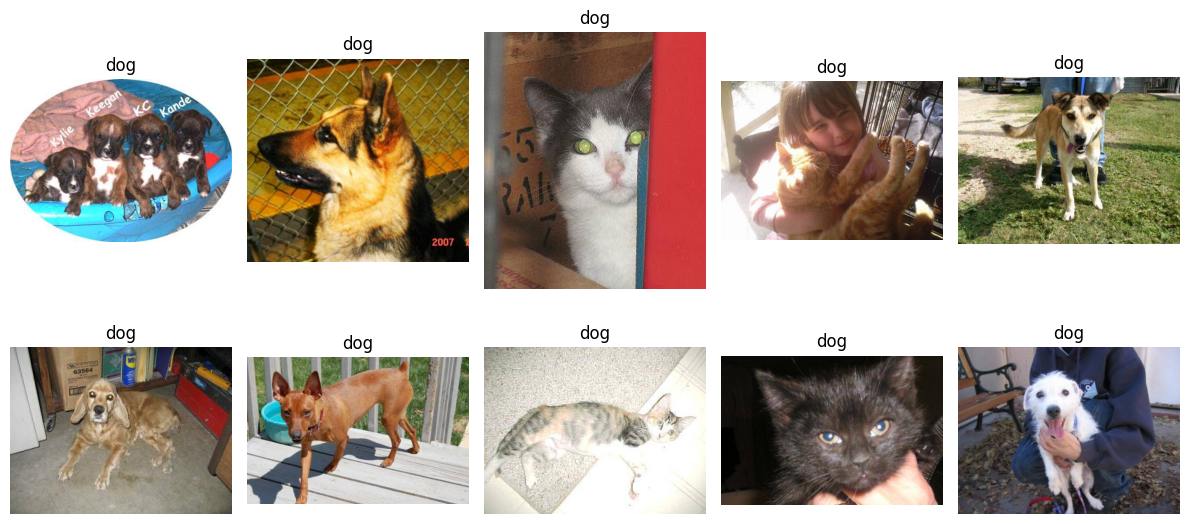

In [32]:
class_ = classes = {0:'cat', 1:'dog'}

def show_image(image_file_path, predicted_label=(), cols=5):
    rows = len(image_file_path) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_path in enumerate(image_file_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        r = random.choice(result['id'].values)
        label = result.loc[result['id'] == r, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

show_image(test_image_files)